## Read time series data and split

In [1]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
#jax.config.update("jax_disable_jit", True)
#jax.config.update("jax_log_compiles", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import inference_func as inference
import tokenizer_lib as tl
import pickle
import matplotlib.pyplot as plt
import visualization_func as visualization

tl.status()

jax 0.8.2 jaxlib 0.8.2
cpu
[CpuDevice(id=0)]


## Pre-processing

* Normalize
* Delta tokens by derivation
* Global discretization

Current setup:
* delta tokens
* n_bins = 4096
* log size bins

Future:
* discretize each column individually

## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```python
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

# Read model

In [2]:
# Load model
file_name = "token_model_20251226_084805.pkl"
with open(f"../models/{file_name}", 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)

X, Y = tl.get_split_data(path="../data", resample_interval=resample_interval)

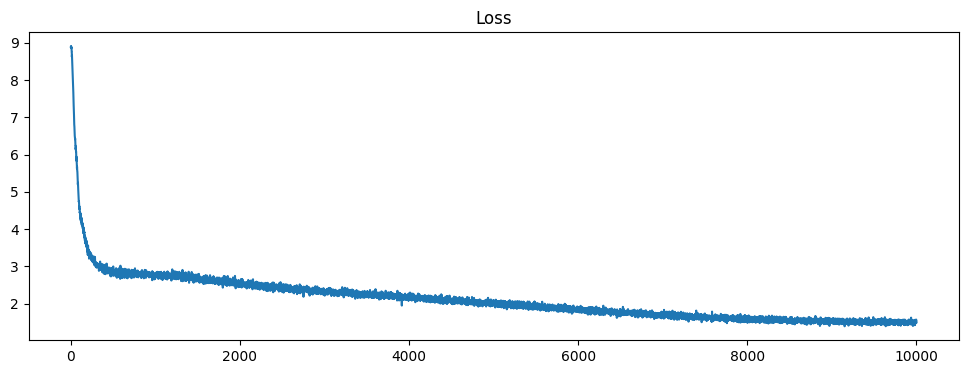

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

In [4]:
# Cross-entropy ~3.5 corresponds to perplexity exp(3.5) ≈ 33. That can be “fine” or “terrible” depending on:
#	•	how many tokens are actually plausible at each step (if only ~tens are plausible, 33 is not crazy),
print(losses[-1], np.exp(losses[-1]))

1.4998738765716553 4.481123859991621


## Autoregressive rollout
* Feed in test_tokens context window (same context +1 out)
* Generate one new token, add to context, adhere to grammar
* When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], we make a new row
* Stop when we have stepped block_size (context window size)
* We should now have a dataframe of new deltas

TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

In [5]:
rng_key = jax.random.PRNGKey(128)

In [22]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480  # number of tokens to predict
t_batch = int(block_size / n_channels) 
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*t_batch)))

# Select a random batch (t)
X_test = X.iloc[t:t+t_batch] 
Y_test = X.iloc[t+t_batch:t+t_batch+t_batch]

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Pre-process future
Y_test_normalized = (Y_test-mu)/sigma
Y_test_normalized = Y_test_normalized.diff().dropna()
Y_test_nv = Y_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_asinh_global(jnp.asarray(X_test_nv), edges, s=s)
Y_test_tok = discretize.encode_asinh_global(jnp.asarray(Y_test_nv), edges, s=s)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, zero_bin)
token_stream = test_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Number of tokens in stream:", len(token_stream))
print("Context window:", block_size)
print("Last context tokens:", token_stream)

Number of tokens: 974
Number of tokens in stream: 480
Context window: 480
Last context tokens: [1891    1    0    2 2152    3 2158    4 1966    5 1989    6 2094    7
 2193    8 1938    1    0    2 1947    3 1966    4 1637    5 1922    6
 2094    8 2045    1    0    2 2028    3 2006    4 2309    5 2175    6
 1945    8 1915    1    0    2 1970    3 1956    4 2199    5 2142    6
 1835    7 1921    8 2117    1    0    2 2077    3 1906    4 1549    5
 1905    6 1835    8 2199    1    0    2 2085    3 1946    4 2102    5
 2125    6 1835    7 1892    8 1968    1    0    2 2182    3 1956    4
 2017    5 2074    6 1728    7 1761    8 2117    1    0    2 2220    3
 1966    4 1827    5 1989    6 1982    8 2205    1    0    2 2206    3
 1966    4 2431    5 2262    6 2265    8 2000    1    0    2 1986    3
 1996    4 2137    5 2121    6 2109    7 2593    8 2043    1    0    2
 1872    3 2006    4 1915    5 2006    7 2701    8 2128    1    0    2
 1879    3 1966    4 2298    5 2242    6 2169    7 25

In [23]:
pd.DataFrame(Y_test_tok)

,0,1,2,3,4,5,6
0,1863,1927,1968,2065,2048,1780,2131
1,1878,2028,2217,2166,2123,2462,1994
2,1899,1997,2217,2183,2123,1518,2108
3,1926,2018,2037,2065,2197,1634,2220
4,1954,2058,2234,2183,2123,2316,2036
...,...,...,...,...,...,...,...
62,2200,2199,2054,1963,2197,1912,1988
63,2014,1987,2014,2065,2123,2184,2096
64,1945,2018,2161,2133,2160,2442,1917
65,1860,1897,2093,2183,2160,2048,2048


In [24]:
rng_key, subkey = jax.random.split(rng_key)
#token_stream_padded = inference.pad_tokens(token_stream)

#new_tokens = inference.generate_continue(
#    variables,
#    model.apply,
#    token_stream=token_stream,
#    rng_key=rng_key,
#    vocab_size=vocab_size,
#    block_size=block_size,
#    max_new_tokens=max_new_tokens,
#    n_channels=n_channels,
#)


In [25]:
## Autoregressive rollout with covariates
# * Specify covariates values
covariate_cols=[1,2,3]
cov_present, cov_value, cov_channels = inference.preprocess_covariates_from_future_matrix(
    future_tokens=Y_test_tok, 
    covariate_cols=covariate_cols,
    zero_bin=zero_bin,
)

DATA_OFFSET = 2 + n_channels
cov_value_tokens = jnp.asarray(Y_test_tok, dtype=jnp.int32) + DATA_OFFSET  # (H, n_channels)

In [26]:
new_tokens = inference.generate_covariate_frames(
    variables, model.apply, token_stream, rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    #max_new_tokens=max_new_tokens,
    n_channels=n_channels,
    cov_value_tokens=cov_value_tokens,
    covariate_channels=jnp.asarray(cov_channels),
    n_frames=32, #t_batch#Y_test_tok.shape[0],    # or whatever horizon
    zero_bin=zero_bin,
    temperature=0.7, 
    top_k=128
)

In [27]:
# Convert from stream to channel matrix
#tokens_padded = inference.pad_tokens(new_tokens)
rows, n = inference.decode_with_channels_stream(new_tokens, n_channels, zero_bin)
new_Y_tok = rows[:n]
#new_Y_tok

In [28]:
print("expected:", Y_test_tok[:10, covariate_cols[0]])
print("got:     ", new_Y_tok[:10, covariate_cols[0]])

expected: [1927 2028 1997 2018 2058 1997 2038 2169 2199 2229]
got:      [1927 2028 1997 2018 2058 1997 2038 2169 2199 2229]


Delta model, so mu is not added back

$$
\frac{(x_t - \mu) - (x_{t-1} - \mu)}{\sigma}
\quad\equiv\quad
\frac{x_t - x_{t-1}}{\sigma}
$$

Issues:
* Scale mismatch at inference, σ during training ≠ σ during rollout
* equal-width bins in z-space: Most mass lives in a tiny central region and many bins are effectively unused
* root cause is biased delta quantization + cumulative summation, not model capacity.

In [29]:
cols = X_test_normalized.columns
start = t + t_batch

# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_rec = discretize.decode_asinh_global(new_Y_tok, mids, s=s)
Y_rec = pd.DataFrame(Y_rec, columns=cols)
Y_rec = Y_rec * sigma # delta model so mu is not added back

#init_values = X_test.iloc[-1].values
init_values = X.iloc[start].values
Y_pred = init_values + jnp.cumsum(Y_rec.values, axis=0)
Y_pred = Y_pred
Y_test = X.iloc[start+1:start+1+len(Y_rec)]
Y_pred = pd.DataFrame(Y_pred, columns=cols, index=Y_test.index)
#Y_pred

In [30]:
#Y_test

In [31]:
visualization.plot_actual_vs_pred(Y_test, Y_pred, col_idx=0).render_notebook()

## Autoregressive channel hinter

Lets mask away some channels and see if the model hints about the missing channels.

In [ ]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()

# Mask out channel 1, 4->
n_cols = X_test_normalized.shape[1]
mask = np.ones(n_cols, dtype=bool)
mask[[1]] = False
mask[2:] = False

X_masked = X_test_normalized.copy()
X_masked.loc[:, ~mask] = 0

X_masked_nv = X_masked.values.astype(np.float32)   # (N, D)

# Discretize
X_masked_tok = discretize.encode_asinh_global(jnp.asarray(X_masked_nv), edges, s=s)
masked_tokens = tokenizer.encode_with_channels_sparse(X_masked_tok, n_channels, zero_bin)
masked_stream = masked_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(masked_tokens))
print("Number of tokens in stream:", len(masked_stream))
print("Context window:", block_size)
print("Last context tokens:", masked_stream)

In [ ]:
X_masked

In [ ]:
masked_stream_padded = inference.pad_tokens(masked_stream)
new_masked_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=masked_stream_padded,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [ ]:
# Convert from sparse stream to all channel matrix
new_masked_tokens_padded = inference.pad_tokens(new_masked_tokens)
rows, n = inference.decode_with_channels_stream(new_masked_tokens_padded, n_channels)
new_masked_tok = rows[:n]
new_masked_tok

In [ ]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_masked_rec = discretize.decode_asinh_global(new_masked_tok, mids, s=s)
Y_masked_rec = pd.DataFrame(Y_masked_rec, columns=X.columns)
Y_masked_rec = Y_masked_rec * sigma # delta model so mu is not added back

pd.DataFrame(Y_masked_rec)

In [ ]:
# Cumsum
init_values = X_test.iloc[-1].values
Y_masked_pred = init_values + jnp.cumsum(Y_masked_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_masked_pred)]
Y_masked_pred = pd.DataFrame(Y_masked_pred, columns=X.columns, index=Y_test.index)

Y_masked_pred

In [ ]:
col = 'Power demand'
#col = 'temp'
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_masked_pred.index, Y_masked_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()